## Аппроксимация Q-функции

В этой тетрадке мы будем использовать библиотеку tensorflow для обучения нейронной сети, хотя можно использовать и любую другую библиотеку. 

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Будем тестировать наши модели на классической задаче с перевернутым маятником:

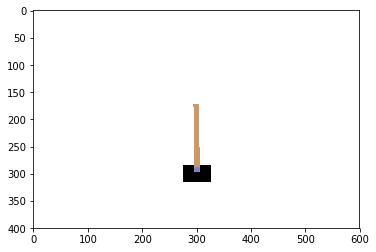

In [2]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [3]:
env.close()

# Глубокое Q-обучение: построение сети

Так как описание состояния в задаче с маятником представляет собой не "сырые" признаки, а уже предобработанные (координаты, углы), нам не нужна для начала сложная архитектура, начнем с такой:

<img src="qlearningscheme.png" caption="Архитектура сети">
Для начала попробуйте использовать только полносвязные слои (__L.Dense__) и линейные активационные функции. Сигмоиды и другие функции не будут работать с ненормализованными входными данными.

In [4]:
import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

Using TensorFlow backend.


In [5]:
network = keras.models.Sequential()
network.add(L.InputLayer(state_dim))
# строим сеть!
#~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~

 
network.add(L.Dense(300, activation="relu"))
network.add(L.Dense(n_actions))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [6]:
import random
def get_action(state, epsilon=0):
    """
    сэмплируем (eps greedy) действие  
    """
    q_values = network.predict(state[None])[0]
    
    ### Ваш код здесь - нужно выбрать действия eps-жадно
    # action = 
    #~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~
    
     
    if epsilon < random.random():
        action = np.argmax(q_values)
    else:
        action = random.choice(range(n_actions))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    return action


In [7]:
assert network.output_shape == (None, n_actions), \
    "убедитесь, что стратегия переводит \
    s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == \
       keras.activations.linear, \
    "убедитесь, что вы предсказываете q без нелинейности"
# проверяем исследование
s = env.reset()
assert np.shape(get_action(s)) == (), \
    "убедитесь, что возвращаете одно действие"
for eps in [0., 0.1, 0.5, 1.0]:
    na = n_actions
    st = np.bincount([get_action(s, epsilon=eps) \
                      for i in range(10000)],
                     minlength=na)
    ba = st.argmax()
    assert abs(
        st[ba] - 10000 * (1 - eps + eps / na)) < 200
    for oa in range(na):
        if oa != ba:
            assert abs(st[oa] - 10000 * (eps / na)) < 200
    print('e=%.1f tests passed' % eps)

W1002 11:30:24.976516 140142519334720 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



e=0.0 tests passed
e=0.1 tests passed
e=0.5 tests passed
e=1.0 tests passed


### Q-обучение через градиентный спуск

Теперь будем приближать Q-функцию агента, минимизируя TD функцию потерь:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2. $$

Основная тонкость состоит в использовании  $Q_{-}(s',a')$. Эта та же самая функция, что и $Q_{\theta}$, которая является выходом нейронной сети, но при обучении сети, мы не пропускаем через эти слои градиенты. Для этого используется функция `tf.stop_gradient`.

In [8]:
# Создаем placeholders для <s, a, r, s'>, 
# а также индикатор окончания эпизода (is_done = True)
states_ph = tf.placeholder('float32', 
                           shape=(None,) + state_dim)
actions_ph = tf.placeholder('int32', shape=[None])
rewards_ph = tf.placeholder('float32', shape=[None])
next_states_ph = tf.placeholder('float32', 
                           shape=(None,) + state_dim)
is_done_ph = tf.placeholder('bool', shape=[None])

In [9]:
# получаем q для всех действий, в текущем состоянии
predicted_qvalues = network(states_ph)

# получаем q-values для выбранного действия
predicted_qvalues_for_actions =\
tf.reduce_sum(
predicted_qvalues * tf.one_hot(actions_ph, n_actions),
    axis=1)

In [10]:
gamma = 0.99

# применяем сеть для получения q-value для next_states_ph
# predicted_next_qvalues =
#~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~

 
predicted_next_qvalues = network(next_states_ph)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# вычисляем V*(next_states) 
# по предсказанным следующим q-values
# next_state_values =
#~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~

 
next_state_values = tf.reduce_max(predicted_next_qvalues, axis=1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Вычисляем target q-values для функции потерь 
# target_qvalues_for_actions = 
#~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~

 
target_qvalues_for_actions = rewards_ph + gamma * next_state_values

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# для последнего действия используем 
# упрощенную формулу Q(s,a) = r(s,a) 
target_qvalues_for_actions =\
tf.where(is_done_ph, rewards_ph, 
         target_qvalues_for_actions)

W1002 11:30:51.522647 140142519334720 deprecation.py:323] From <ipython-input-10-a831ceba3ea3>:35: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2. $$


In [11]:
### среднеквадратичная функция потерь stop_gradient
# loss = 
#~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~

 
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions))**2
loss = tf.reduce_mean(loss)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# применяем AdamOptimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [12]:
assert tf.gradients(loss, \
    [predicted_qvalues_for_actions])[0] is not None, \
"убедитесь, что обновление выполняется\
только для выбранного действия"
assert tf.gradients(loss, \
    [predicted_next_qvalues])[0] is None, \
"убедитесь, что вы не распространяете градиент Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, \
"убедитесь, что вы предсказываете q для всех действий,\
следующего состояния"
assert next_state_values.shape.ndims == 1, \
"убедитесь, что вы вычислили V(s') как максимум\
только по оси действий, а не по всем осям"
assert target_qvalues_for_actions.shape.ndims == 1, \
"что-то не так с целевыми q-значениями,\
они должны быть вектором"

### Playing the game

In [13]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """генерация сессии"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], 
                rewards_ph: [r], next_states_ph: [next_s], 
                is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [14]:
epsilon = 0.8

In [15]:
for i in range(100):
    session_rewards = [generate_session(epsilon=epsilon, 
                        train=True) for _ in range(500)]
    print("epoch #{}\tmean r = {:.3f}\tepsilon = {:.3f}"
          .format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.95
    epsilon = max(0.1, epsilon)
    assert epsilon >= 1e-4, \
    "убедитесь, что epsilon не становится < 0"
    if np.mean(session_rewards) > 300:
        print ("Принято!")
        break


FailedPreconditionError: Error while reading resource variable beta1_power from Container: localhost. This could mean that the variable was uninitialized. Not found: Resource localhost/beta1_power/N10tensorflow3VarE does not exist.
	 [[node Adam/update_dense_1/kernel/ResourceApplyAdam/ReadVariableOp (defined at <ipython-input-11-e61309f3b57c>:12) ]]

Original stack trace for 'Adam/update_dense_1/kernel/ResourceApplyAdam/ReadVariableOp':
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/lib/python3.7/dist-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/usr/local/lib/python3.7/dist-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.7/dist-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/usr/local/lib/python3.7/dist-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.7/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.7/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.7/dist-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-e61309f3b57c>", line 12, in <module>
    train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/optimizer.py", line 413, in minimize
    name=name)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/optimizer.py", line 614, in apply_gradients
    update_ops.append(processor.update_op(self, grad))
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/optimizer.py", line 171, in update_op
    update_op = optimizer._resource_apply_dense(g, self._v)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/adam.py", line 177, in _resource_apply_dense
    use_locking=self._use_locking)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/gen_training_ops.py", line 1399, in resource_apply_adam
    use_nesterov=use_nesterov, name=name)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 527, in _apply_op_helper
    preferred_dtype=default_dtype)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 1224, in internal_convert_to_tensor
    ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 1507, in _dense_var_to_tensor
    return var._dense_var_to_tensor(dtype=dtype, name=name, as_ref=as_ref)  # pylint: disable=protected-access
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 1462, in _dense_var_to_tensor
    return self.value()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 851, in value
    return self._read_variable_op()
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 935, in _read_variable_op
    self._dtype)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_resource_variable_ops.py", line 587, in read_variable_op
    "ReadVariableOp", resource=resource, dtype=dtype, name=name)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


### Интерпретация результатов

\begin{itemize}
\item mean reward -- среднее вознаграждение за эпизод. В случае корректной реализации, этот показатель будет низким первые 5 эпох и только затем будет возрастать и сойдется на 20-30 эпох в зависииости от архитектуры сети.
\item Если сеть не достигает нужных результатов к концу цикла, попробуйте увеличить число нейронов в скрытом слое или поменяйте $\epsilon$.
\item epsilon -- обеспечивает стремление агента исследовать среду. Можно искусственно изменять малые значения $\epsilon$ при низких результатах на 0.1 - 0.5.
\end{itemize}